# GameTheory-4-NashEquilibrium

**Navigation** : [<< 3-Topology2x2](GameTheory-3-Topology2x2.ipynb) | [Index](README.md) | [5-ZeroSum-Minimax >>](GameTheory-5-ZeroSum-Minimax.ipynb)

**Side tracks** : [4b-Lean-NashExistence](GameTheory-4b-Lean-NashExistence.ipynb) | [4c-NashExistence-Python](GameTheory-4c-NashExistence-Python.ipynb)

## Equilibres de Nash : Purs et Mixtes

Ce notebook explore en profondeur les **equilibres de Nash**, concept central de la theorie des jeux.

### Objectifs

1. Definir formellement l'equilibre de Nash
2. Calculer les equilibres purs par best response
3. Introduire les strategies mixtes
4. Calculer les equilibres mixtes
5. Utiliser les algorithmes : Support Enumeration, Lemke-Howson
6. Analyser parametriquement les equilibres

### Duree estimee : 60 minutes

### Theoreme de Nash (1950)
> Tout jeu fini a au moins un equilibre de Nash (potentiellement en strategies mixtes).

In [1]:
# Imports
import numpy as np
import nashpy as nash
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from typing import List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

## 1. Definition formelle

### Equilibre de Nash

Un profil de strategies $\sigma^* = (\sigma_1^*, \sigma_2^*, ..., \sigma_n^*)$ est un **equilibre de Nash** si :

$$u_i(\sigma_i^*, \sigma_{-i}^*) \geq u_i(\sigma_i, \sigma_{-i}^*) \quad \forall i \in N, \forall \sigma_i \in \Sigma_i$$

Autrement dit, **aucun joueur n'a interet a devier unilateralement**.

### Types d'equilibres

| Type | Description |
|------|-------------|
| **Nash pur** | Chaque joueur joue une action deterministe |
| **Nash mixte** | Au moins un joueur randomise entre plusieurs actions |

In [2]:
class Game2x2:
    """
    Jeu 2x2 avec calcul d'equilibres.
    """
    
    def __init__(self, A: np.ndarray, B: np.ndarray, 
                 row_labels: List[str] = None,
                 col_labels: List[str] = None,
                 name: str = "Game"):
        self.A = np.array(A, dtype=float)
        self.B = np.array(B, dtype=float)
        self.name = name
        self.row_labels = row_labels or ['R0', 'R1']
        self.col_labels = col_labels or ['C0', 'C1']
        
        # Jeu Nashpy pour algorithmes
        self.nash_game = nash.Game(self.A, self.B)
    
    def payoffs(self, sigma_row: np.ndarray, sigma_col: np.ndarray) -> Tuple[float, float]:
        """Calcule les gains esperes pour des strategies mixtes."""
        u_row = sigma_row @ self.A @ sigma_col
        u_col = sigma_row @ self.B @ sigma_col
        return u_row, u_col
    
    def best_response_row(self, sigma_col: np.ndarray) -> np.ndarray:
        """Meilleure reponse de Row a la strategie mixte de Col."""
        expected = self.A @ sigma_col
        max_val = np.max(expected)
        # Retourne une strategie pure (BR peut etre multiple)
        return np.array([1.0, 0.0]) if expected[0] >= expected[1] else np.array([0.0, 1.0])
    
    def best_response_col(self, sigma_row: np.ndarray) -> np.ndarray:
        """Meilleure reponse de Col a la strategie mixte de Row."""
        expected = sigma_row @ self.B
        max_val = np.max(expected)
        return np.array([1.0, 0.0]) if expected[0] >= expected[1] else np.array([0.0, 1.0])
    
    def display(self):
        """Affiche le jeu."""
        print(f"\n{self.name}")
        print("=" * 40)
        print(f"            {self.col_labels[0]:>12} {self.col_labels[1]:>12}")
        for i, label in enumerate(self.row_labels):
            print(f"{label:>10}  ({self.A[i,0]:>4.1f},{self.B[i,0]:>4.1f})  ({self.A[i,1]:>4.1f},{self.B[i,1]:>4.1f})")

# Exemples
pd = Game2x2(
    A=[[3, 0], [5, 1]],
    B=[[3, 5], [0, 1]],
    row_labels=['Cooperer', 'Defaire'],
    col_labels=['Cooperer', 'Defaire'],
    name="Dilemme du Prisonnier"
)
pd.display()


Dilemme du Prisonnier
                Cooperer      Defaire
  Cooperer  ( 3.0, 3.0)  ( 0.0, 5.0)
   Defaire  ( 5.0, 0.0)  ( 1.0, 1.0)


## 2. Equilibres de Nash purs

Un equilibre en strategies **pures** est une paire d'actions $(i^*, j^*)$ telle que :
- $A_{i^*, j^*} \geq A_{i, j^*}$ pour tout $i$ (Row joue best response)
- $B_{i^*, j^*} \geq B_{i^*, j}$ pour tout $j$ (Col joue best response)

In [3]:
def find_pure_nash(game: Game2x2) -> List[Tuple[int, int]]:
    """
    Trouve tous les equilibres de Nash purs par enumeration.
    """
    equilibria = []
    m, n = game.A.shape
    
    for i in range(m):
        for j in range(n):
            # i est meilleure reponse a j ?
            row_br = all(game.A[i, j] >= game.A[k, j] for k in range(m))
            # j est meilleure reponse a i ?
            col_br = all(game.B[i, j] >= game.B[i, l] for l in range(n))
            
            if row_br and col_br:
                equilibria.append((i, j))
    
    return equilibria

def display_equilibria(game: Game2x2):
    """Affiche les equilibres d'un jeu."""
    game.display()
    
    pure_eq = find_pure_nash(game)
    print(f"\nEquilibres de Nash purs: {len(pure_eq)}")
    
    for (i, j) in pure_eq:
        u_row, u_col = game.A[i, j], game.B[i, j]
        print(f"  ({game.row_labels[i]}, {game.col_labels[j]}) -> gains ({u_row}, {u_col})")

# Tester sur plusieurs jeux
games = [
    Game2x2([[3,0],[5,1]], [[3,5],[0,1]], ['C','D'], ['C','D'], "Prisoner's Dilemma"),
    Game2x2([[4,0],[3,3]], [[4,3],[0,3]], ['Stag','Hare'], ['Stag','Hare'], "Stag Hunt"),
    Game2x2([[3,0],[0,2]], [[2,0],[0,3]], ['Opera','Football'], ['Opera','Football'], "Battle of Sexes"),
    Game2x2([[1,-1],[-1,1]], [[-1,1],[1,-1]], ['Pile','Face'], ['Pile','Face'], "Matching Pennies"),
]

for g in games:
    display_equilibria(g)
    print()


Prisoner's Dilemma
                       C            D
         C  ( 3.0, 3.0)  ( 0.0, 5.0)
         D  ( 5.0, 0.0)  ( 1.0, 1.0)

Equilibres de Nash purs: 1
  (D, D) -> gains (1.0, 1.0)


Stag Hunt
                    Stag         Hare
      Stag  ( 4.0, 4.0)  ( 0.0, 3.0)
      Hare  ( 3.0, 0.0)  ( 3.0, 3.0)

Equilibres de Nash purs: 2
  (Stag, Stag) -> gains (4.0, 4.0)
  (Hare, Hare) -> gains (3.0, 3.0)


Battle of Sexes
                   Opera     Football
     Opera  ( 3.0, 2.0)  ( 0.0, 0.0)
  Football  ( 0.0, 0.0)  ( 2.0, 3.0)

Equilibres de Nash purs: 2
  (Opera, Opera) -> gains (3.0, 2.0)
  (Football, Football) -> gains (2.0, 3.0)


Matching Pennies
                    Pile         Face
      Pile  ( 1.0,-1.0)  (-1.0, 1.0)
      Face  (-1.0, 1.0)  ( 1.0,-1.0)

Equilibres de Nash purs: 0



### Analyse des equilibres purs

Les resultats ci-dessus illustrent les **quatre types fondamentaux** de jeux 2x2 :

| Jeu | Nash purs | Interpretation |
|-----|-----------|----------------|
| **Prisoner's Dilemma** | 1 (D,D) | Equilibre unique mais sous-optimal - le "dilemme" |
| **Stag Hunt** | 2 | Probleme de **coordination** - quel equilibre choisir ? |
| **Battle of Sexes** | 2 | Probleme de **selection** - interets partiellement alignes |
| **Matching Pennies** | 0 | Conflit pur - equilibre mixte obligatoire |

**Question fondamentale** : Quand un jeu a **plusieurs equilibres**, comment les joueurs se coordonnent-ils ?

- **Focal points** (Schelling) : Certains equilibres sont plus "saillants" culturellement
- **Communication** : Parler avant de jouer peut aider (mais pas toujours)
- **Histoire** : Les interactions passees creent des precedents

**Quand il n'y a aucun equilibre pur** (Matching Pennies) : Les joueurs doivent randomiser pour ne pas etre previsibles. C'est la base des strategies mixtes.

## 3. Strategies mixtes

### Definition

Une **strategie mixte** est une distribution de probabilite sur les actions pures.

Pour un joueur avec actions $\{1, ..., m\}$, une strategie mixte est $\sigma = (\sigma_1, ..., \sigma_m)$ avec :
- $\sigma_i \geq 0$ pour tout $i$
- $\sum_i \sigma_i = 1$

### Gain espere

Le gain espere du joueur Row avec strategies mixtes $(\sigma, \tau)$ est :
$$u_{Row}(\sigma, \tau) = \sigma^T A \tau = \sum_{i,j} \sigma_i \tau_j A_{ij}$$

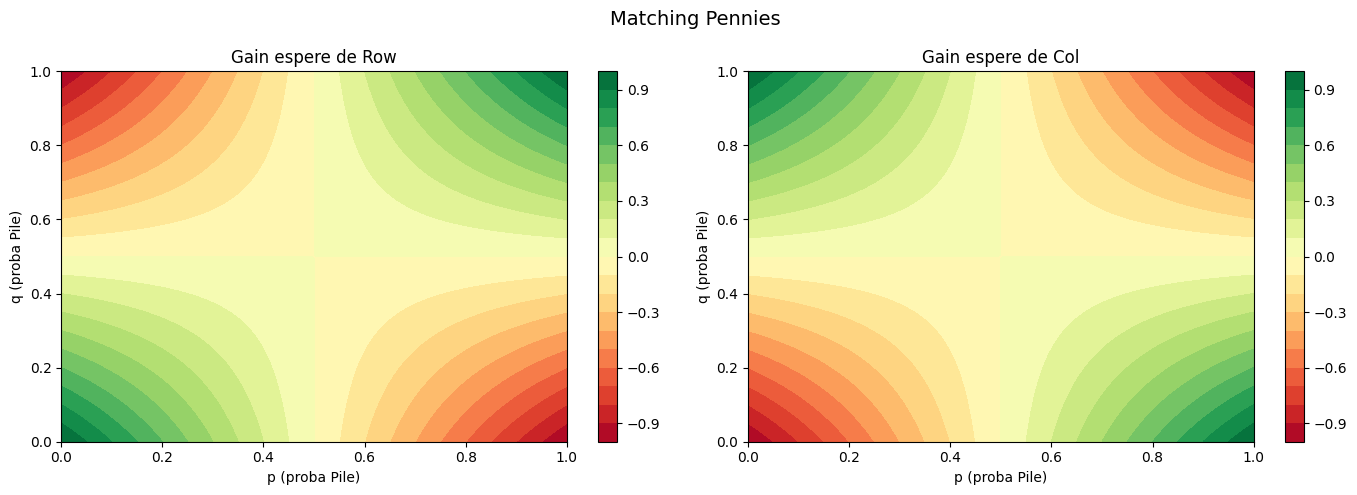

In [4]:
def visualize_mixed_strategies(game: Game2x2):
    """
    Visualise les gains en fonction des strategies mixtes.
    
    Pour un jeu 2x2, on peut parametrer:
    - sigma_row = (p, 1-p) avec p in [0,1]
    - sigma_col = (q, 1-q) avec q in [0,1]
    """
    p_vals = np.linspace(0, 1, 100)
    q_vals = np.linspace(0, 1, 100)
    P, Q = np.meshgrid(p_vals, q_vals)
    
    # Calcul des gains esperes
    U_row = np.zeros_like(P)
    U_col = np.zeros_like(P)
    
    for i, p in enumerate(p_vals):
        for j, q in enumerate(q_vals):
            sigma_row = np.array([p, 1-p])
            sigma_col = np.array([q, 1-q])
            U_row[j, i], U_col[j, i] = game.payoffs(sigma_row, sigma_col)
    
    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Gain Row
    im0 = axes[0].contourf(P, Q, U_row, levels=20, cmap='RdYlGn')
    plt.colorbar(im0, ax=axes[0])
    axes[0].set_xlabel(f'p (proba {game.row_labels[0]})')
    axes[0].set_ylabel(f'q (proba {game.col_labels[0]})')
    axes[0].set_title(f'Gain espere de Row')
    
    # Gain Col
    im1 = axes[1].contourf(P, Q, U_col, levels=20, cmap='RdYlGn')
    plt.colorbar(im1, ax=axes[1])
    axes[1].set_xlabel(f'p (proba {game.row_labels[0]})')
    axes[1].set_ylabel(f'q (proba {game.col_labels[0]})')
    axes[1].set_title(f'Gain espere de Col')
    
    fig.suptitle(game.name, fontsize=14)
    plt.tight_layout()
    plt.show()

# Visualiser Matching Pennies
mp = Game2x2([[1,-1],[-1,1]], [[-1,1],[1,-1]], ['Pile','Face'], ['Pile','Face'], "Matching Pennies")
visualize_mixed_strategies(mp)

## 4. Calcul des equilibres mixtes

### Condition d'indifference

A l'equilibre mixte, un joueur qui joue plusieurs actions avec probabilite positive doit etre **indifferent** entre ces actions.

Pour le joueur Row jouant $(p, 1-p)$ contre Col jouant $(q, 1-q)$ :
- Gain de Row en jouant action 0 : $A_{00}q + A_{01}(1-q)$
- Gain de Row en jouant action 1 : $A_{10}q + A_{11}(1-q)$

A l'equilibre mixte (si $0 < p < 1$), ces deux gains sont egaux.

In [5]:
def compute_mixed_nash_2x2(game: Game2x2) -> Optional[Tuple[np.ndarray, np.ndarray]]:
    """
    Calcule l'equilibre mixte d'un jeu 2x2 par la condition d'indifference.
    
    Returns:
        (sigma_row, sigma_col) ou None si pas d'equilibre mixte interieur.
    """
    A, B = game.A, game.B
    
    # Condition d'indifference pour Row:
    # A[0,0]*q + A[0,1]*(1-q) = A[1,0]*q + A[1,1]*(1-q)
    # (A[0,0] - A[0,1] - A[1,0] + A[1,1]) * q = A[1,1] - A[0,1]
    
    denom_q = A[0,0] - A[0,1] - A[1,0] + A[1,1]
    if abs(denom_q) < 1e-10:
        return None  # Pas de solution unique
    
    q = (A[1,1] - A[0,1]) / denom_q
    
    # Condition d'indifference pour Col:
    # B[0,0]*p + B[1,0]*(1-p) = B[0,1]*p + B[1,1]*(1-p)
    
    denom_p = B[0,0] - B[1,0] - B[0,1] + B[1,1]
    if abs(denom_p) < 1e-10:
        return None
    
    p = (B[1,1] - B[1,0]) / denom_p
    
    # Verifier que c'est un equilibre interieur valide
    if 0 <= p <= 1 and 0 <= q <= 1:
        sigma_row = np.array([p, 1-p])
        sigma_col = np.array([q, 1-q])
        return sigma_row, sigma_col
    
    return None

# Tester sur Matching Pennies
mp = Game2x2([[1,-1],[-1,1]], [[-1,1],[1,-1]], ['Pile','Face'], ['Pile','Face'], "Matching Pennies")
mp.display()

mixed_eq = compute_mixed_nash_2x2(mp)
if mixed_eq:
    sigma_row, sigma_col = mixed_eq
    print(f"\nEquilibre mixte:")
    print(f"  Row: ({sigma_row[0]:.3f}, {sigma_row[1]:.3f})")
    print(f"  Col: ({sigma_col[0]:.3f}, {sigma_col[1]:.3f})")
    print(f"  Gains esperes: {mp.payoffs(sigma_row, sigma_col)}")


Matching Pennies
                    Pile         Face
      Pile  ( 1.0,-1.0)  (-1.0, 1.0)
      Face  (-1.0, 1.0)  ( 1.0,-1.0)

Equilibre mixte:
  Row: (0.500, 0.500)
  Col: (0.500, 0.500)
  Gains esperes: (np.float64(0.0), np.float64(0.0))


In [6]:
# Calculer tous les equilibres (purs et mixtes) pour plusieurs jeux
def analyze_all_equilibria(game: Game2x2):
    """Analyse complete des equilibres."""
    game.display()
    
    # Equilibres purs
    pure_eq = find_pure_nash(game)
    print(f"\nEquilibres purs: {len(pure_eq)}")
    for (i, j) in pure_eq:
        print(f"  ({game.row_labels[i]}, {game.col_labels[j]})")
    
    # Equilibre mixte
    mixed_eq = compute_mixed_nash_2x2(game)
    if mixed_eq:
        sigma_row, sigma_col = mixed_eq
        # Verifier que c'est vraiment un equilibre interieur
        if 0 < sigma_row[0] < 1 and 0 < sigma_col[0] < 1:
            u_row, u_col = game.payoffs(sigma_row, sigma_col)
            print(f"\nEquilibre mixte:")
            print(f"  Row: {sigma_row} (p={sigma_row[0]:.3f})")
            print(f"  Col: {sigma_col} (q={sigma_col[0]:.3f})")
            print(f"  Gains: ({u_row:.3f}, {u_col:.3f})")
    else:
        print("\nPas d'equilibre mixte interieur")
    
    print()

# Analyser les jeux classiques
for g in games:
    analyze_all_equilibria(g)
    print("-" * 50)


Prisoner's Dilemma
                       C            D
         C  ( 3.0, 3.0)  ( 0.0, 5.0)
         D  ( 5.0, 0.0)  ( 1.0, 1.0)

Equilibres purs: 1
  (D, D)

Pas d'equilibre mixte interieur

--------------------------------------------------

Stag Hunt
                    Stag         Hare
      Stag  ( 4.0, 4.0)  ( 0.0, 3.0)
      Hare  ( 3.0, 0.0)  ( 3.0, 3.0)

Equilibres purs: 2
  (Stag, Stag)
  (Hare, Hare)

Equilibre mixte:
  Row: [0.75 0.25] (p=0.750)
  Col: [0.75 0.25] (q=0.750)
  Gains: (3.000, 3.000)

--------------------------------------------------

Battle of Sexes
                   Opera     Football
     Opera  ( 3.0, 2.0)  ( 0.0, 0.0)
  Football  ( 0.0, 0.0)  ( 2.0, 3.0)

Equilibres purs: 2
  (Opera, Opera)
  (Football, Football)

Equilibre mixte:
  Row: [0.6 0.4] (p=0.600)
  Col: [0.4 0.6] (q=0.400)
  Gains: (1.200, 1.200)

--------------------------------------------------

Matching Pennies
                    Pile         Face
      Pile  ( 1.0,-1.0)  (-1.0, 1.0)

### Interpretation des equilibres mixtes

Les resultats revelent des proprietes fondamentales des equilibres mixtes :

**Prisoner's Dilemma** : Pas d'equilibre mixte interieur
- Pourquoi ? Parce que Defaire **domine** Cooperer
- Si une strategie domine, pas besoin de mixer

**Stag Hunt** : Equilibre mixte (75%, 25%)
- Les joueurs jouent Stag avec proba 75%
- Gain espere = 3 (egal au gain de Hare,Hare)
- **Paradoxe** : L'equilibre mixte donne le meme gain que le "mauvais" equilibre pur !

**Battle of Sexes** : Equilibre mixte (60%, 40%)
- Row joue Opera plus souvent car il prefere Opera
- Mais le gain espere (1.2) est **inferieur** aux deux equilibres purs !
- C'est le **cout de la mis-coordination**

**Matching Pennies** : Equilibre mixte (50%, 50%)
- Seul equilibre du jeu
- Gain espere = 0 (jeu equitable)
- Toute deviation est **exploitable** par l'adversaire

**Lecon cle** : L'equilibre mixte n'est pas un "compromis" - c'est le point ou chaque joueur est **indifferent** entre ses actions, donc ne peut pas etre exploite.

## 5. Algorithmes de Nashpy

Nashpy implemente plusieurs algorithmes pour trouver les equilibres de Nash.

In [7]:
def compare_nash_algorithms(game: Game2x2):
    """
    Compare les algorithmes de Nashpy pour trouver les equilibres.
    """
    print(f"\n{game.name}")
    print("=" * 50)
    
    # 1. Support Enumeration
    print("\n1. Support Enumeration:")
    for eq in game.nash_game.support_enumeration():
        sigma_row, sigma_col = eq
        u = game.payoffs(sigma_row, sigma_col)
        print(f"   Row: {np.round(sigma_row, 4)}, Col: {np.round(sigma_col, 4)}, Gains: {np.round(u, 4)}")
    
    # 2. Lemke-Howson
    print("\n2. Lemke-Howson:")
    try:
        for eq in game.nash_game.lemke_howson_enumeration():
            sigma_row, sigma_col = eq
            u = game.payoffs(sigma_row, sigma_col)
            print(f"   Row: {np.round(sigma_row, 4)}, Col: {np.round(sigma_col, 4)}, Gains: {np.round(u, 4)}")
    except Exception as e:
        print(f"   Erreur: {e}")
    
    # 3. Vertex Enumeration
    print("\n3. Vertex Enumeration:")
    try:
        for eq in game.nash_game.vertex_enumeration():
            sigma_row, sigma_col = eq
            u = game.payoffs(sigma_row, sigma_col)
            print(f"   Row: {np.round(sigma_row, 4)}, Col: {np.round(sigma_col, 4)}, Gains: {np.round(u, 4)}")
    except Exception as e:
        print(f"   Erreur: {e}")

# Comparer sur Battle of the Sexes (2 purs + 1 mixte)
bos = Game2x2([[3,0],[0,2]], [[2,0],[0,3]], ['Opera','Football'], ['Opera','Football'], "Battle of Sexes")
compare_nash_algorithms(bos)


Battle of Sexes

1. Support Enumeration:
   Row: [1. 0.], Col: [1. 0.], Gains: [3. 2.]
   Row: [0. 1.], Col: [0. 1.], Gains: [2. 3.]
   Row: [0.6 0.4], Col: [0.4 0.6], Gains: [1.2 1.2]

2. Lemke-Howson:
   Row: [1. 0.], Col: [1. 0.], Gains: [3. 2.]
   Row: [0. 1.], Col: [0. 1.], Gains: [2. 3.]
   Row: [1. 0.], Col: [1. 0.], Gains: [3. 2.]
   Row: [0. 1.], Col: [0. 1.], Gains: [2. 3.]

3. Vertex Enumeration:
   Row: [ 1. -0.], Col: [1. 0.], Gains: [3. 2.]
   Row: [0. 1.], Col: [-0.  1.], Gains: [2. 3.]
   Row: [0.6 0.4], Col: [0.4 0.6], Gains: [1.2 1.2]


## 6. Analyse parametrique

Comment les equilibres changent-ils quand on modifie les gains ?

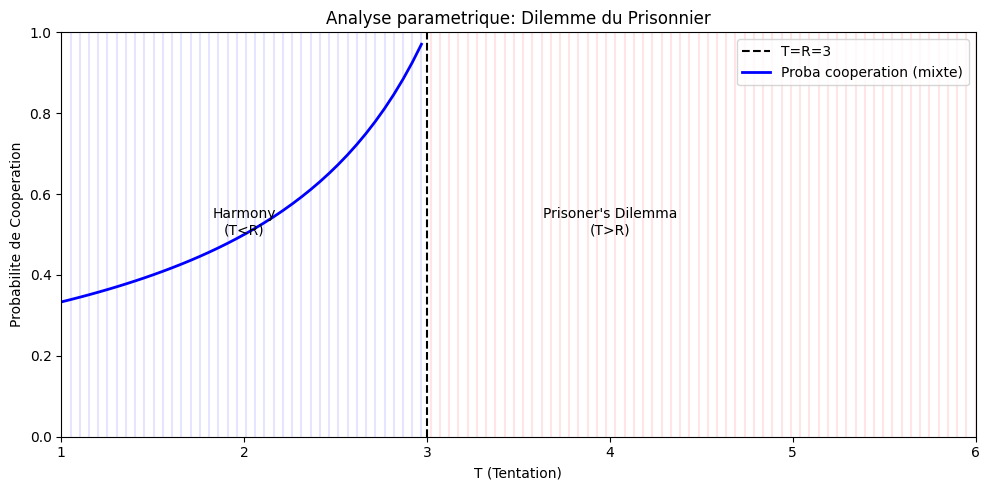

In [8]:
def parametric_analysis_pd(T_range: np.ndarray):
    """
    Analyse parametrique du Dilemme du Prisonnier.
    
    Matrice standard:
        (R, R)  (S, T)
        (T, S)  (P, P)
    
    Avec T > R > P > S (tentaion, reward, punishment, sucker)
    On fixe R=3, P=1, S=0 et on varie T.
    """
    R, P, S = 3, 1, 0
    
    equilibrium_types = []
    mixed_probs = []
    
    for T in T_range:
        A = np.array([[R, S], [T, P]])
        B = np.array([[R, T], [S, P]])
        game = Game2x2(A, B)
        
        pure_eq = find_pure_nash(game)
        mixed_eq = compute_mixed_nash_2x2(game)
        
        # Classifier le type de jeu
        if len(pure_eq) == 1 and pure_eq[0] == (1, 1):
            if T > R:  # Prisoner's Dilemma
                eq_type = 'PD'
            else:  # Harmony
                eq_type = 'Harmony'
        elif len(pure_eq) == 2:
            eq_type = 'Coord'
        else:
            eq_type = 'Other'
        
        equilibrium_types.append(eq_type)
        
        if mixed_eq and 0 < mixed_eq[0][0] < 1:
            mixed_probs.append(mixed_eq[0][0])
        else:
            mixed_probs.append(np.nan)
    
    # Visualisation
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Marquer les regions
    colors = {'PD': 'red', 'Harmony': 'green', 'Coord': 'blue', 'Other': 'gray'}
    for i, (T, eq_type) in enumerate(zip(T_range, equilibrium_types)):
        ax.axvline(T, color=colors.get(eq_type, 'gray'), alpha=0.1)
    
    # Ligne de separation T=R
    ax.axvline(R, color='black', linestyle='--', label=f'T=R={R}')
    
    # Probabilite de cooperation a l'equilibre mixte
    ax.plot(T_range, mixed_probs, 'b-', linewidth=2, label='Proba cooperation (mixte)')
    
    ax.set_xlabel('T (Tentation)')
    ax.set_ylabel('Probabilite de Cooperation')
    ax.set_title('Analyse parametrique: Dilemme du Prisonnier')
    ax.legend()
    ax.set_xlim(T_range[0], T_range[-1])
    ax.set_ylim(0, 1)
    
    # Annotations
    ax.annotate('Harmony\n(T<R)', xy=(2, 0.5), fontsize=10, ha='center')
    ax.annotate("Prisoner's Dilemma\n(T>R)", xy=(4, 0.5), fontsize=10, ha='center')
    
    plt.tight_layout()
    plt.show()

# Varier T de 1 a 6
parametric_analysis_pd(np.linspace(1, 6, 100))

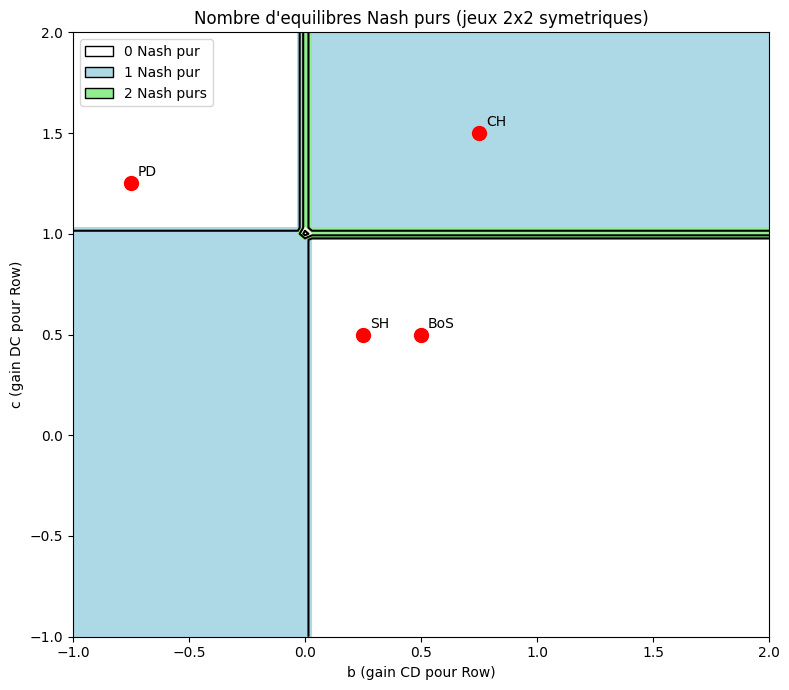

In [9]:
def visualize_equilibrium_regions():
    """
    Visualise les regions d'equilibres dans l'espace des parametres.
    
    Pour un jeu 2x2 symetrique avec gains (a,b,c,d) pour Row:
        (a, a)  (b, c)
        (c, b)  (d, d)
    
    On fixe a=1, d=0 et on varie b et c.
    """
    a, d = 1, 0
    b_range = np.linspace(-1, 2, 100)
    c_range = np.linspace(-1, 2, 100)
    B_grid, C_grid = np.meshgrid(b_range, c_range)
    
    n_pure_nash = np.zeros_like(B_grid)
    
    for i, b in enumerate(b_range):
        for j, c in enumerate(c_range):
            A_mat = np.array([[a, b], [c, d]])
            B_mat = np.array([[a, c], [b, d]])  # Symetrique
            game = Game2x2(A_mat, B_mat)
            pure_eq = find_pure_nash(game)
            n_pure_nash[j, i] = len(pure_eq)
    
    # Visualisation
    fig, ax = plt.subplots(figsize=(8, 7))
    
    im = ax.contourf(B_grid, C_grid, n_pure_nash, levels=[0, 1, 2, 3, 4], 
                     colors=['white', 'lightblue', 'lightgreen', 'lightyellow'])
    ax.contour(B_grid, C_grid, n_pure_nash, levels=[0.5, 1.5, 2.5, 3.5], colors='black')
    
    # Marquer les jeux classiques
    # PD: a=3, b=0, c=5, d=1 -> normalise: a=1, b=-0.75, c=1.25, d=0
    classic_games = {
        'PD': (-0.75, 1.25),
        'SH': (0.25, 0.5),
        'BoS': (0.5, 0.5),
        'CH': (0.75, 1.5),
    }
    
    for name, (b, c) in classic_games.items():
        if b_range[0] <= b <= b_range[-1] and c_range[0] <= c <= c_range[-1]:
            ax.plot(b, c, 'ro', markersize=10)
            ax.annotate(name, (b, c), textcoords="offset points", xytext=(5,5))
    
    ax.set_xlabel('b (gain CD pour Row)')
    ax.set_ylabel('c (gain DC pour Row)')
    ax.set_title('Nombre d\'equilibres Nash purs (jeux 2x2 symetriques)')
    
    # Legende
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='white', edgecolor='black', label='0 Nash pur'),
        Patch(facecolor='lightblue', edgecolor='black', label='1 Nash pur'),
        Patch(facecolor='lightgreen', edgecolor='black', label='2 Nash purs'),
    ]
    ax.legend(handles=legend_elements, loc='upper left')
    
    plt.tight_layout()
    plt.show()

visualize_equilibrium_regions()

### Ce que nous apprend l'analyse parametrique

Les graphiques ci-dessus revelent une structure profonde :

**Transition de phase a T=R (Tentation = Recompense)** :
- **T < R** (gauche) : Le jeu est "Harmony" - cooperer est dominant
- **T > R** (droite) : Le jeu devient un "Dilemme du Prisonnier"

C'est une **bifurcation** : un petit changement de parametre transforme radicalement la dynamique du jeu.

**Regions dans l'espace (b,c)** :
- La **topologie** des equilibres depend des inegalites entre gains
- Les jeux classiques (PD, SH, BoS, CH) occupent des regions specifiques
- Les frontieres correspondent a des **degenerescences** (equilibres multiples coincident)

**Application pratique** :
- Si vous concevez un mecanisme (encheres, contrat, etc.), l'analyse parametrique vous dit **ou sont les risques**
- Un petit changement d'incitation peut faire passer d'un monde cooperatif a un dilemme social
- Les concepteurs de mecanismes cherchent souvent a **eloigner** le systeme des frontieres critiques

## 7. Jeux plus grands : algorithme de support enumeration

Pour les jeux plus grands que 2x2, l'algorithme de **support enumeration** est plus general.

In [10]:
# Jeu 3x3: Pierre-Feuille-Ciseaux
A_rps = np.array([
    [0, -1, 1],
    [1, 0, -1],
    [-1, 1, 0]
])
B_rps = -A_rps  # Jeu a somme nulle

rps = nash.Game(A_rps, B_rps)

print("Pierre-Feuille-Ciseaux (3x3)")
print("="*40)
print("\nMatrice des gains (Row):")
print(A_rps)

print("\nEquilibres de Nash:")
for eq in rps.support_enumeration():
    sigma_row, sigma_col = eq
    print(f"\n  Row: {np.round(sigma_row, 4)}")
    print(f"  Col: {np.round(sigma_col, 4)}")
    u_row = sigma_row @ A_rps @ sigma_col
    print(f"  Gain Row: {u_row:.4f}")

Pierre-Feuille-Ciseaux (3x3)

Matrice des gains (Row):
[[ 0 -1  1]
 [ 1  0 -1]
 [-1  1  0]]

Equilibres de Nash:

  Row: [0.3333 0.3333 0.3333]
  Col: [0.3333 0.3333 0.3333]
  Gain Row: 0.0000


In [11]:
# Jeu asymetrique 3x2
A_asym = np.array([
    [3, 1],
    [0, 4],
    [2, 2]
])
B_asym = np.array([
    [2, 3],
    [4, 1],
    [1, 2]
])

asym = nash.Game(A_asym, B_asym)

print("Jeu asymetrique 3x2")
print("="*40)
print("\nMatrice A (gains Row):")
print(A_asym)
print("\nMatrice B (gains Col):")
print(B_asym)

print("\nEquilibres de Nash:")
for i, eq in enumerate(asym.support_enumeration()):
    sigma_row, sigma_col = eq
    u_row = sigma_row @ A_asym @ sigma_col
    u_col = sigma_row @ B_asym @ sigma_col
    print(f"\nEquilibre {i+1}:")
    print(f"  Row: {np.round(sigma_row, 4)}")
    print(f"  Col: {np.round(sigma_col, 4)}")
    print(f"  Gains: ({u_row:.3f}, {u_col:.3f})")

Jeu asymetrique 3x2

Matrice A (gains Row):
[[3 1]
 [0 4]
 [2 2]]

Matrice B (gains Col):
[[2 3]
 [4 1]
 [1 2]]

Equilibres de Nash:

Equilibre 1:
  Row: [0.75 0.25 0.  ]
  Col: [0.5 0.5]
  Gains: (2.000, 2.500)

Equilibre 2:
  Row: [-0.    0.25  0.75]
  Col: [0.5 0.5]
  Gains: (2.000, 1.750)


## 8. Resume

### Points cles

| Concept | Description |
|---------|-------------|
| **Equilibre de Nash** | Profil ou personne ne veut devier |
| **Strategie mixte** | Distribution de probabilites sur les actions |
| **Condition d'indifference** | A l'equilibre mixte, gain egal pour toutes les actions jouees |
| **Theoreme de Nash** | Tout jeu fini a au moins un equilibre |

### Algorithmes

| Algorithme | Complexite | Description |
|------------|-----------|-------------|
| Support Enumeration | Exponentielle | Enumere tous les supports possibles |
| Lemke-Howson | Polynomiale (pivot) | Suit un chemin de pivots |
| Vertex Enumeration | Exponentielle | Enumere les sommets des polytopes |

### Observations importantes

1. Un jeu peut avoir **plusieurs** equilibres de Nash
2. Les equilibres peuvent etre **Pareto-domines** (PD)
3. L'equilibre mixte garantit l'existence mais peut etre **fragile**
4. L'analyse parametrique revele les **transitions** entre types de jeux

## 9. Exercices

### Exercice 1
Trouvez l'equilibre mixte de Battle of the Sexes a la main, puis verifiez avec Nashpy.

### Exercice 2
Creez un jeu 3x3 avec exactement 2 equilibres de Nash purs.

### Exercice 3
Analysez comment l'equilibre mixte de Stag Hunt varie quand on change le gain de la cooperation.

In [12]:
# Espace pour les exercices

---

**Notebook precedent**: [GameTheory-3-Topology2x2](GameTheory-3-Topology2x2.ipynb)  
**Notebook suivant**: [GameTheory-5-ZeroSum-Minimax](GameTheory-5-ZeroSum-Minimax.ipynb)